In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# from scipy import signal
# from scipy.io import wavfile

from tqdm.notebook import tqdm

import librosa
import librosa.display

import torch
import torch.nn as nn

from common_audio import *
from audio_dataset import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float

print(device)

cpu


In [6]:
sr = 10000
duration = 4.9
voice_ds = AudioDataSet('datasets/LibriSpeech/LibriSpeech/dev-clean', sr=sr, duration=duration)
# ads = AudioDataSet('datasets/urban/UrbanSound8K/audio')


In [10]:
def generate_tones(sr, duration, freq, amplitude=None):
    if amplitude is None:
        amplitude = np.ones_like(freq)
    freq, amplitude = freq[:, None], amplitude[:, None]
    length = int(sr*duration)
    full = np.tile(np.arange(length), (freq.shape[1], 1))
    y = amplitude * np.sin(2*np.pi/sr * freq * full)
    return y


In [ ]:


tone_y = generate_tones(sr, duration, np.array([1024, 2048]), np.array([1, 2]))
play_audio(tone_y[0], sr)

show_spectrogram(audio_to_spectrogram(tone_y[0], sr), sr)

# Naive Method

Make a neural network to just take out the tone

# Our Method

add details...

In [39]:
class VoiceRecogNet(nn.Module):
    def __init__(self):
        super(VoiceRecogNet, self).__init__()
        self.maxpool = nn.MaxPool2d((2,2))
        self.conv1 = nn.Conv2d(1, 4, 3, padding=1)
        self.conv2 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 64, 3, padding=1)
        self.linear = nn.Linear(12288, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 1)
        
        self.opt = torch.optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.maxpool(x)
        x = torch.tanh(x)

        x = self.conv2(x)
        x = self.maxpool(x)
        x = torch.tanh(x)

        x = self.conv3(x)
        x = self.maxpool(x)
        x = torch.tanh(x)
        
        x = x.view(x.shape[0], -1)
        
        x = self.linear(x)
        x = torch.relu(x)
        
        x = self.linear2(x)
        x = torch.relu(x)
        
        x = self.linear3(x)
        x = torch.sigmoid(x)
        
        return x
    
vrn = VoiceRecogNet().to(device)

In [27]:
# create test set
voice_ds.reset_next()
X_test_voice = voice_ds.load_next(100, pbar=tqdm())
X_test_tone = generate_tones(sr, duration, np.linspace(500, 2000, 100))

X_test = np.concatenate((X_test_voice, X_test_tone), axis=0)
Y_test = np.concatenate((np.ones(X_test_voice.shape[0]), np.zeros(X_test_tone.shape[0])), axis=0)

X_test = audios_to_spectrograms(X_test, sr, normalize=True)


In [69]:
tin = torch.from_numpy(X_test).to(device,dtype)[:,None, :, :]
tout = vrn.forward(tin).detach().cpu().numpy()[:, 0]

print('Accuracy: ', ((tout>0.5) == (Y_test>0.5)).sum()/len(Y_test))

Accuracy:  0.04


0.6977925
0.61458004
0.48627466
0.37102553
0.23876016
0.14889307
0.06923959
0.07224403
0.02555867
0.015887555
0.005020765
0.0011314509
0.00027792604
7.1111506e-05
3.022899e-05
1.6880458e-05
6.1062434e-05
2.9623563e-06
3.8237e-06
2.0623413e-06
4.559757e-07
8.936641e-05
1.7881396e-07
5.4902055e-05
8.3446515e-08
5.960465e-08
6.556512e-08
2.9802322e-08
2.9802322e-08
5.9604646e-09
3.814711e-07
5.9604646e-09
4.3511582e-07
5.9604646e-09
2.0034155e-05
2.0861664e-07
0.00013091699
0.0
0.0
0.0008870716
5.9604646e-09
5.9604646e-09
5.9604646e-09
0.0
0.0
0.0
2.8442466e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.9604646e-09
0.0
1.192093e-08
3.0697167e-06
0.0
0.0
4.9472095e-07
7.4928657e-06
0.0
0.02365501
0.0
0.0
0.0
8.642675e-08
2.7120336e-06
9.1330396e-05
0.002220119
0.01229555
0.00028540942
8.538615e-06
4.6491692e-07
5.662442e-08
1.4901161e-08
5.9604646e-09
0.0
0.0
0.0
5.9604646e-09
5.9604646e-09
0.0
0.0
5.9604646e-09
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.2053766e-07
0.0
0.0
0.0



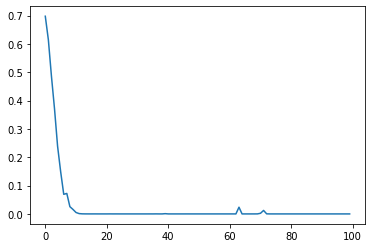

In [74]:
crit = nn.BCELoss()
losses = []
batch_num = 10
for epoch in tqdm(range(100)):
    X_batch_voice = voice_ds.load_next(batch_num, pbar=None)
    X_batch_tone = generate_tones(sr, duration, np.linspace(500, 2000, batch_num))

    X_batch = np.concatenate((X_batch_voice, X_batch_tone), axis=0)
    Y_batch = np.concatenate((np.ones(X_batch_voice.shape[0]), np.zeros(X_batch_tone.shape[0])), axis=0)

    X_batch = audios_to_spectrograms(X_batch, sr, normalize=True)
    X_batch = torch.from_numpy(X_batch).to(device,dtype)[:,None, :, :]
    Y_batch = torch.from_numpy(Y_batch).to(device,dtype)

    
    vrn.opt.zero_grad()
    Y = vrn.forward(X_batch)[:, 0]
    loss = crit(Y, Y_batch)
    
    loss.backward()
    
    vrn.opt.step()
    
    loss = loss.detach().cpu().numpy()
    losses.append(loss)
    print(loss)
    
plt.plot(np.arange(len(losses)), losses)

In [75]:
tin = torch.from_numpy(X_test).to(device,dtype)[:,None, :, :]
tout = vrn.forward(tin).detach().cpu().numpy()[:, 0]

print('Accuracy: ', ((tout>0.5) == (Y_test>0.5)).sum()/len(Y_test))

Accuracy:  1.0
